# Zillow Clustering Project

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import math

import scipy.stats as stats
from scipy.stats import zscore, iqr, percentileofscore, scoreatpercentile

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import sklearn.metrics
import sklearn.linear_model
from sklearn.feature_selection import RFE

import wrangle_zillow as wr
import preprocessing as pr
import explore as ex
import evaluate as ev

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

# Acquire
The DataFrame below contains all fields from the `properties_2017` table as well as the descriptive fields from the appropriate tables in the `zillow` database. The data is filtered to only include properties that have a `latitude` and `longitude` value.

In [2]:
df = wr.get_zillow_data()
print(f"Our DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Our DataFrame has 77580 rows and 68 columns.


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


> What kind of data types are we working with? How many null values are in each column?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77580 entries, 0 to 77579
Data columns (total 68 columns):
id                              77580 non-null int64
parcelid                        77580 non-null int64
airconditioningtypeid           25007 non-null float64
architecturalstyletypeid        207 non-null float64
basementsqft                    50 non-null float64
bathroomcnt                     77580 non-null float64
bedroomcnt                      77580 non-null float64
buildingclasstypeid             15 non-null float64
buildingqualitytypeid           49810 non-null float64
calculatedbathnbr               76964 non-null float64
decktypeid                      614 non-null float64
finishedfloor1squarefeet        6037 non-null float64
calculatedfinishedsquarefeet    77379 non-null float64
finishedsquarefeet12            73924 non-null float64
finishedsquarefeet13            42 non-null float64
finishedsquarefeet15            3027 non-null float64
finishedsquarefeet50          

> **We will need to address the abudance of null values and change some of the data types before we can begin our analysis.**

> Let's take a look at some of the summary statistics before we being preparing our data.

In [4]:
df.describe()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,7.758000e+04,7.758000e+04,25007.000000,207.000000,50.000000,77580.000000,77580.000000,15.000000,49810.000000,76964.000000,614.0,6037.000000,77379.000000,73924.000000,42.000000,3027.000000,6037.000000,386.000000,77580.000000,8289.000000,76964.000000,25520.000000,25520.000000,1539.0,49572.000000,7.758000e+04,7.758000e+04,6.932200e+04,16174.0,869.000000,465.0,1074.0,15079.0,77580.000000,7.758000e+04,76108.000000,77580.000000,30974.000000,77530.000000,77580.000000,50.0,10106.000000,223.000000,50704.000000,2393.000000,70.000000,77310.000000,17599.000000,172.0,7.746500e+04,7.757900e+04,77580.0,7.757800e+04,77575.000000,2900.000000,7.733300e+04,77580.000000
mean,1.495404e+06,1.300828e+07,1.812013,7.386473,679.720000,2.298492,3.053222,3.933333,6.533728,2.316388,66.0,1366.165314,1784.925923,1760.274945,1388.761905,2354.491245,1381.388935,2082.500000,6048.813998,1.191217,2.250104,1.815282,350.047061,1.0,3.921811,3.400837e+07,-1.182037e+08,2.997309e+04,1.0,517.930955,1.0,1.0,1.0,261.824465,6.049124e+07,33684.165817,2534.522235,187725.110544,96586.691539,1.476257,7.0,1.009598,6.040359,1.110307,305.460928,216.385714,1968.611396,1.434286,1.0,1.892796e+05,4.901476e+05,2016.0,3.011500e+05,5995.927626,14.088276,6.049667e+13,0.016800
std,8.609700e+05,3.519376e+06,2.965768,2.728030,689.703546,0.996726,1.140472,0.258199,1.722082,0.979684,0.0,670.701336,954.247864,934.349898,122.220874,1186.985442,725.792665,1240.382784,20.747162,0.490980,0.966486,0.588340,261.646070,0.0,3.594770,2.652856e+05,3.594078e+05,1.233042e+05,0.0,156.569664,0.0,0.0,0.0,5.141564,2.058953e+05,47212.464556,801.445328,165045.086058,3793.527616,2.823673,0.0,0.118572,0.556035,1.169955,238.735241,190.177514,23.793037,0.544515,0.0,2.304095e+05,6.537942e+05,0.0,4.927219e+05,7628.816490,2.181281,1.533329e+12,0.170739
min,3.490000e+02,1.071186e+07,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,66.0,44.000000,128.000000,128.000000,1056.000000,598.000000,44.000000,380.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.000000,3.333953e+07,-1.194754e+08,2.360000e+02,1.0,24.000000,1.0,1.0,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,4.000000,1.000000,11.000000,12.000000,1824.000000,1.000000,1.0,4.400000e+01,1.000000e+03,2016.0,1.610000e+02,19.920000,3.000000,6.037101e+13,-4.655420
25%,7.521430e+05,1.153820e+07,1.000000,7.000000,273.000000,2.000000,2.000000,4.000000,6.000000,2.000000,66.0,955.000000,1182.000000,1172.000000,1344.000000,1624.000000,956.000000,993.750000,6037.000000,1.000000,2.000000,2.000000,0.000000,1.0,2.000000,3.381463e+07,-1.184150e+08,5.700000e+03,1.0,424.000000,1.0,1.0,1.0,261.000000,6.037311e+07,12447.000000,1286.000000,46736.000000,96193.000000,0.000000,7.0,1.000000,6.000000,1.000000,170.000000,61.500000,1953.000000,1.000000,1.0,8.417100e+04,2.068990e+05,2016.0,8.529325e+04,2712.650000,14.000000,6.037311e+13,-0.024310
50%,1.498256e+06,1.253056e+07,1.000000,7.000000,515.000000,2.000000,3.000000,4.000000,6.000000,2.000000,66.0,1257.000000,1542.000000,1523.000000,1440.000000,2088.000

> Finally, let's plot the distributions of the data to help us identify outliers that need to be addressed.

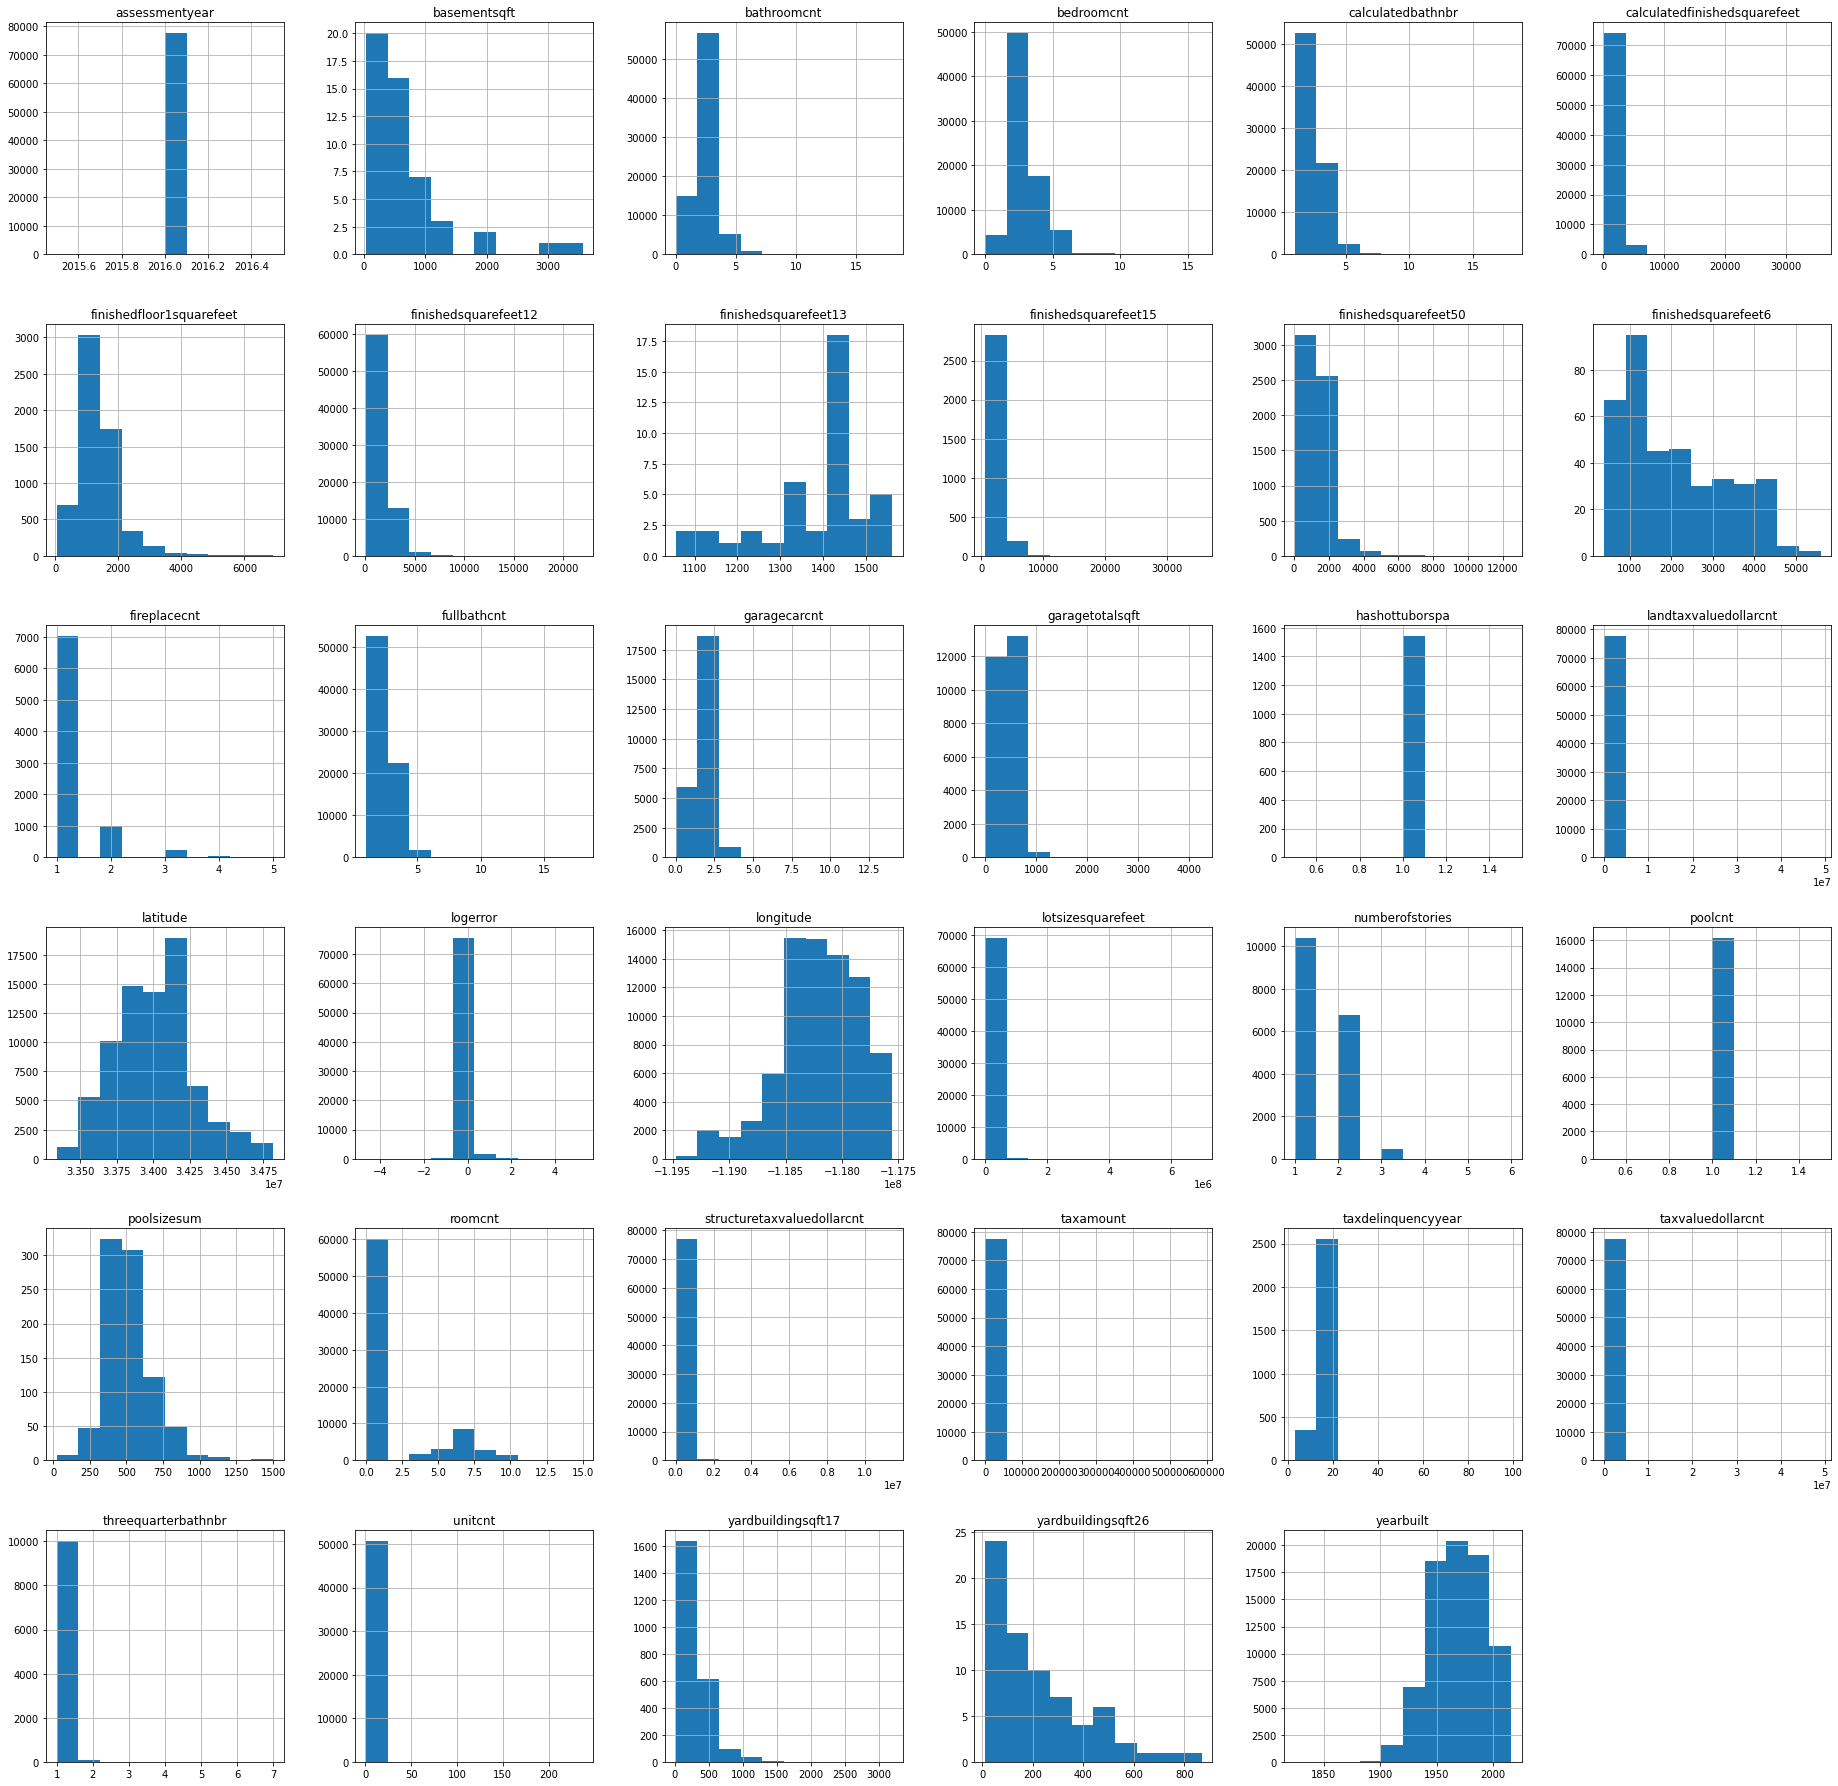

In [5]:
# let's drop the numeric id fields as they will not serve us in our hunt for outliers.
df.drop(columns=["id", "parcelid", "airconditioningtypeid", "architecturalstyletypeid", "buildingclasstypeid", "buildingqualitytypeid", "decktypeid", "fips", "heatingorsystemtypeid", "pooltypeid10", "pooltypeid2", "pooltypeid7", "propertylandusetypeid", "rawcensustractandblock", "regionidcity", "regionidcounty", "regionidneighborhood", "regionidzip", "storytypeid", "typeconstructiontypeid", "fireplaceflag", "censustractandblock"]).hist(figsize=(32, 32))
plt.show()

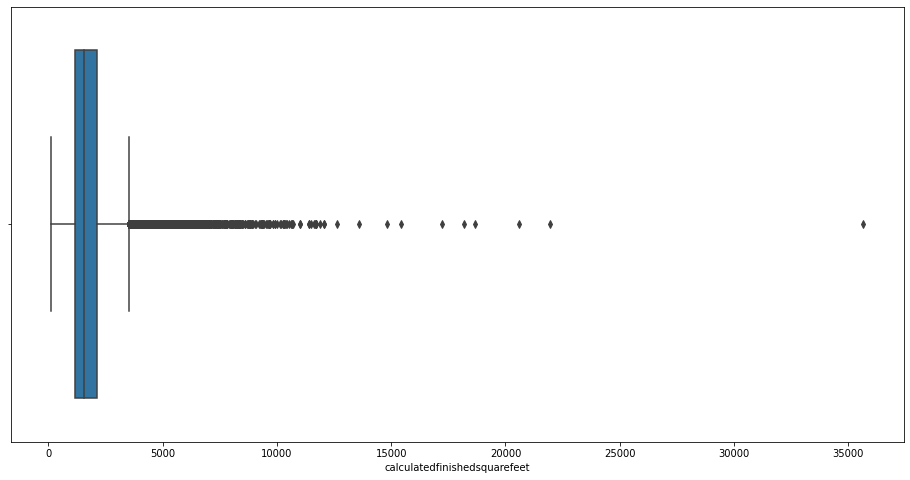

In [6]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df.calculatedfinishedsquarefeet)
plt.show()

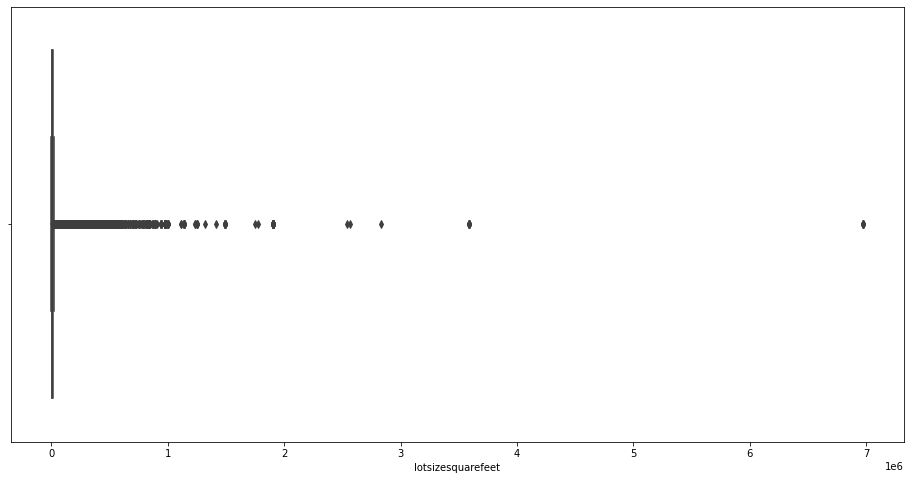

In [7]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df.lotsizesquarefeet)
plt.show()

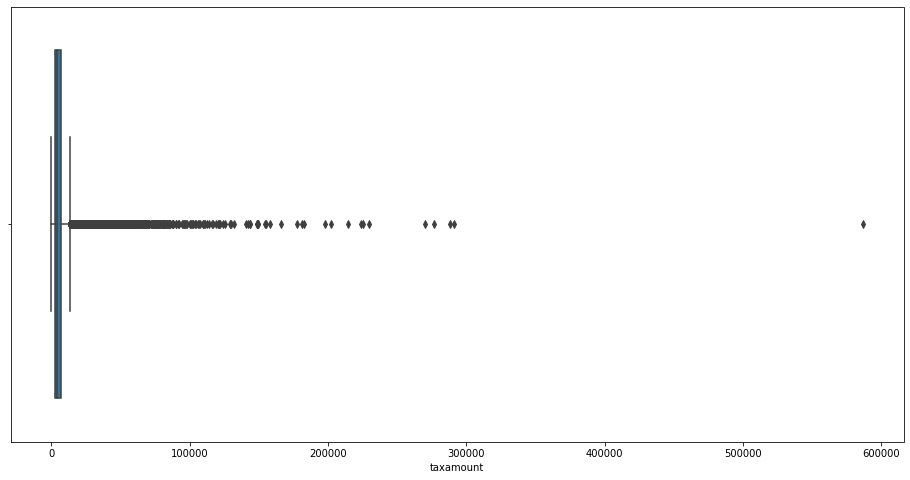

In [8]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df.taxamount)
plt.show()

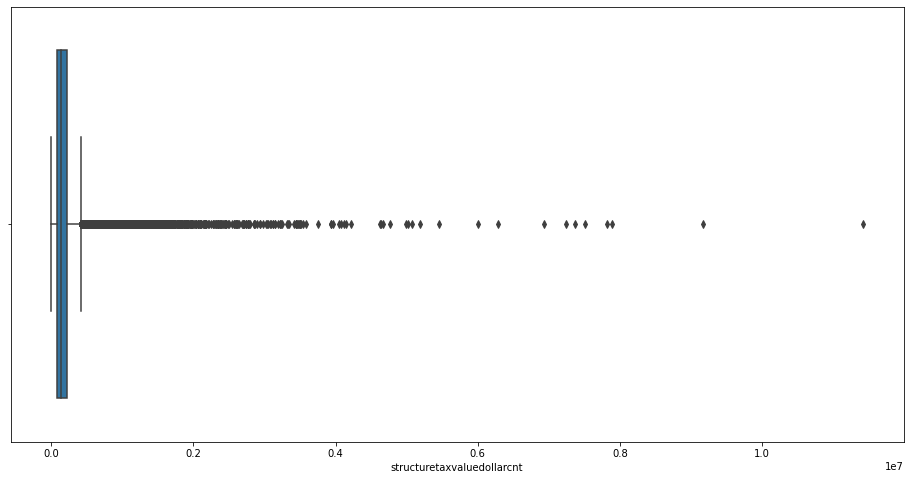

In [9]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df.structuretaxvaluedollarcnt)
plt.show()

> **Now that we have a general idea of what our data looks like and where outliers need to be addressed, let's move into preparation.**

---
# Prepare

## Explanation of `prep_zillow` function
The function does the following:
1. Removes any properties that cannot be interpreted as single unit/single family homes
2. Removes fields that will not add any value to our analysis (i.e., identifier fields and those with redundant information)
3. Drops columns and indices that are missing more than 60% of their respective data
4. Imputes missing values remaining after the function in number 3 has been called (excluding the `regionidcity` field)
5. Drops indices deemed unworthy of imputation either because there are too few values missing to put in the effort of imputing or imputation is not a practical means of handling the missing data (e.g., `censustractandblock`)
6. Creates new `county`, `tax_rate`, `yard_size`, and `price_per_sq_ft` variables
7. Detects and removes outliers
8. Resets the index of the DataFrame
9. Drops former index column

In [10]:
df = wr.prep_zillow(df)
print(df.shape)
df.head()

(44440, 33)


,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate,yard_size,price_per_sq_ft
0,14297519,3.5,4.0,6.0,3.5,3100.0,6059.0,3.0,33634931.0,-117869207.0,4506.0,122,6.059063e+07,53571.0,1286.0,96978.0,0.0,1.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,None,Single Family Residential,Orange County,0.010763,1406.0,330.090968
1,17052889,1.0,2.0,6.0,1.0,1465.0,6111.0,1.0,34449266.0,-119281531.0,12647.0,1110,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,None,Single Family Residential,Ventura County,0.012225,11182.0,316.723549
2,14186244,2.0,3.0,6.0,2.0,1243.0,6059.0,2.0,33886168.0,-117823170.0,8432.0,122,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,None,Single Family Residential,Orange County,0.011488,7189.0,454.366854
3,12177905,3.0,4.0,8.0,3.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,13038.0,0101,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Central,Single Family Residential,Los Angeles County,0.012247,10662.0,61.087121
4,12069064,1.0,2.0,5.0,1.0,738.0,6037.0,1.0,34149214.0,-118239357.0,4214.0,0100,6.037302e+07,45457.0,3101.0,96325.0,0.0,1.0,1922.0,18890.0,218552.0,2016.0,199662.0,2366.08,6.037302e+13,0.101723,2017-01-01,None,Single Family Residential,Los Angeles County,0.010826,3476.0,296.140921


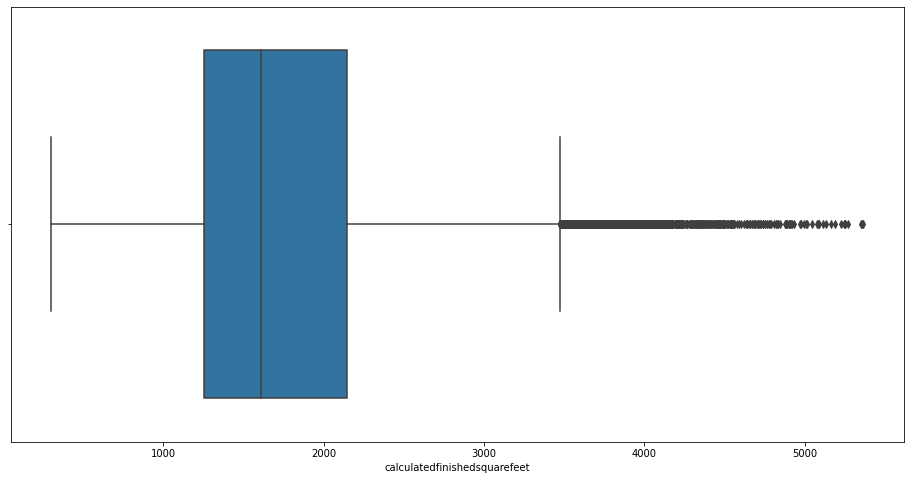

In [11]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df.calculatedfinishedsquarefeet)
plt.show()

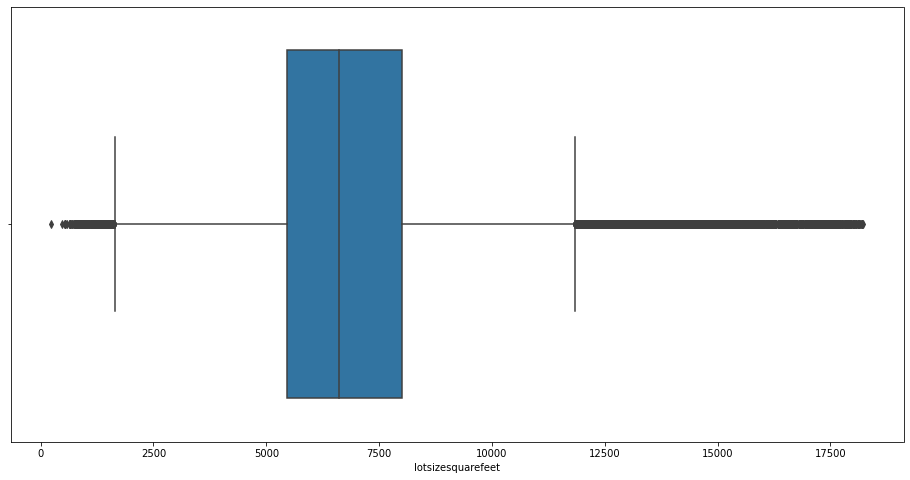

In [12]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df.lotsizesquarefeet)
plt.show()

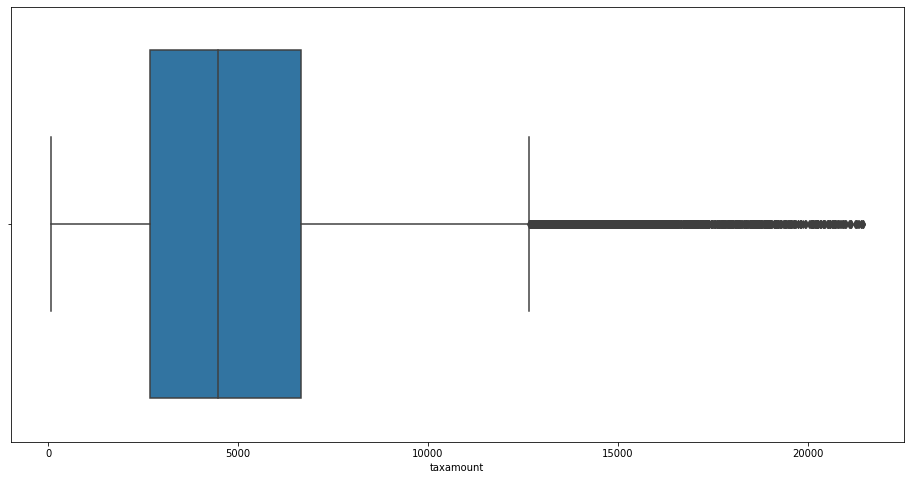

In [13]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df.taxamount)
plt.show()

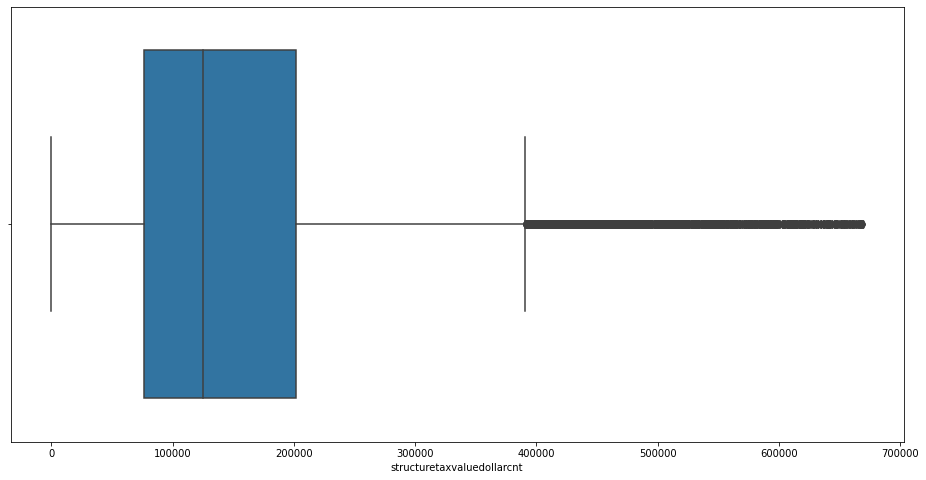

In [14]:
plt.figure(figsize=(16, 8))
sns.boxplot(x=df.structuretaxvaluedollarcnt)
plt.show()

> Looks like the outliers have been handled.

## Preprocessing

### Explanation of `split_impute_scale` function
The function does the following:
1. Splits prepared DataFrame into `train`, `validate`, and `test`
2. KNN imputes the regionidcity for `train`, `validate`, and `test`
3. Scales all appropriate numeric fields for `train`, `validate`, and `test`
4. Returns the `imputer`, `scaler`, `train`, `validate`, and `test` variables

In [15]:
imputer, scaler, train, validate, test = pr.split_impute_scale(df)
imputer

KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=5, weights='uniform')

In [16]:
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [17]:
print(f"   train shape = {train.shape}")
print(f"validate shape = {validate.shape}")
print(f"    test shape = {test.shape}")

   train shape = (26664, 33)
validate shape = (8888, 33)
    test shape = (8888, 33)


In [18]:
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate,yard_size,price_per_sq_ft
35915,12457622,0.0,0.333333,0.2,0.0,0.196721,6037,0.0,0.372619,0.663738,0.390181,0100,0.006367,46298,3101,96239,0.000000,0.0,0.328467,0.100685,0.123589,0.0,0.122217,0.139519,0.006367,0.639213,2017-07-31,Floor/Wall,Single Family Residential,Los Angeles County,0.494151,0.444233,0.182773
40456,12906513,0.2,0.333333,0.5,0.2,0.191389,6037,0.2,0.557788,0.876809,0.415971,0100,0.004048,39308,3101,96494,0.000000,0.0,0.620438,0.154533,0.074533,0.0,0.031406,0.086354,0.004048,0.638314,2017-08-25,Central,Single Family Residential,Los Angeles County,0.500428,0.473054,0.111496
13143,14023137,0.2,0.333333,0.5,0.2,0.223385,6059,0.2,0.268013,0.825818,0.311512,122,0.297302,47568,1286,97004,0.583333,0.0,0.642336,0.071548,0.037447,0.0,0.022059,0.051657,0.297302,0.633058,2017-04-04,None,Single Family Residential,Orange County,0.614679,0.353183,0.046645
5357,11459439,0.2,0.500000,0.3,0.2,0.256962,6037,0.2,0.456542,0.550515,0.298815,0100,0.002372,12447,3101,96026,0.000000,0.0,0.510949,0.210432,0.398417,0.0,0.433715,0.425683,0.002372,0.632350,2017-02-13,Floor/Wall,Single Family Residential,Los Angeles County,0.463512,0.329661,0.480345
21808,11461483,0.0,0.333333,0.5,0.0,0.194549,6037,0.0,0.452833,0.547211,0.243679,0100,0.002373,12447,3101,96026,0.000000,0.0,0.510949,0.298840,0.406335,0.0,0.401818,0.431475,0.002373,0.638097,2017-05-22,Floor/Wall,Single Family Residential,Los Angeles County,0.458386,0.290300,0.614044


In [19]:
train.isna().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
heatingorsystemdesc             0
propertylandusedesc             0
county        

In [20]:
validate.isna().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
heatingorsystemdesc             0
propertylandusedesc             0
county        

In [21]:
test.isna().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
heatingorsystemdesc             0
propertylandusedesc             0
county        

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26664 entries, 35915 to 44208
Data columns (total 33 columns):
parcelid                        26664 non-null object
bathroomcnt                     26664 non-null float64
bedroomcnt                      26664 non-null float64
buildingqualitytypeid           26664 non-null float64
calculatedbathnbr               26664 non-null float64
calculatedfinishedsquarefeet    26664 non-null float64
fips                            26664 non-null object
fullbathcnt                     26664 non-null float64
latitude                        26664 non-null float64
longitude                       26664 non-null float64
lotsizesquarefeet               26664 non-null float64
propertycountylandusecode       26664 non-null object
rawcensustractandblock          26664 non-null float64
regionidcity                    26664 non-null object
regionidcounty                  26664 non-null object
regionidzip                     26664 non-null object
roomcnt      

In [23]:
train.describe()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,tax_rate,yard_size,price_per_sq_ft
count,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.0,26664.000000,26664.000000,26664.000000,26664.0,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000
mean,0.235599,0.375281,0.506353,0.235610,0.290394,0.223192,0.483721,0.667710,0.369073,0.171338,0.166867,0.0,0.614816,0.232658,0.219352,0.0,0.185819,0.235188,0.171363,0.639572,0.506974,0.393719,0.240556
std,0.164639,0.145734,0.125317,0.164631,0.140015,0.161033,0.191289,0.188599,0.155072,0.281994,0.263833,0.0,0.162610,0.169416,0.161463,0.0,0.162575,0.161092,0.281993,0.023093,0.141135,0.152825,0.158046
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.333333,0.500000,0.200000,0.188623,0.200000,0.347763,0.559738,0.281321,0.004059,0.000000,0.0,0.525547,0.113620,0.099747,0.0,0.057253,0.121221,0.004060,0.633759,0.423053,0.309653,0.122566
50%,0.200000,0.333333,0.500000,0.200000,0.257555,0.200000,0.476627,0.691754,0.345598,0.006766,0.000000,0.0,0.598540,0.186139,0.189161,0.0,0.149651,0.204950,0.006769,0.638018,0.469987,0.377479,0.223358
75%,0.400000,0.500000,0.500000,0.400000,0.362631,0.400000,0.608299,0.806844,0.425790,0.297008,0.416667,0.0,0.722628,0.301223,0.295778,0.0,0.266565,0.307096,0.297008,0.642504,0.554137,0.455428,0.326916
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


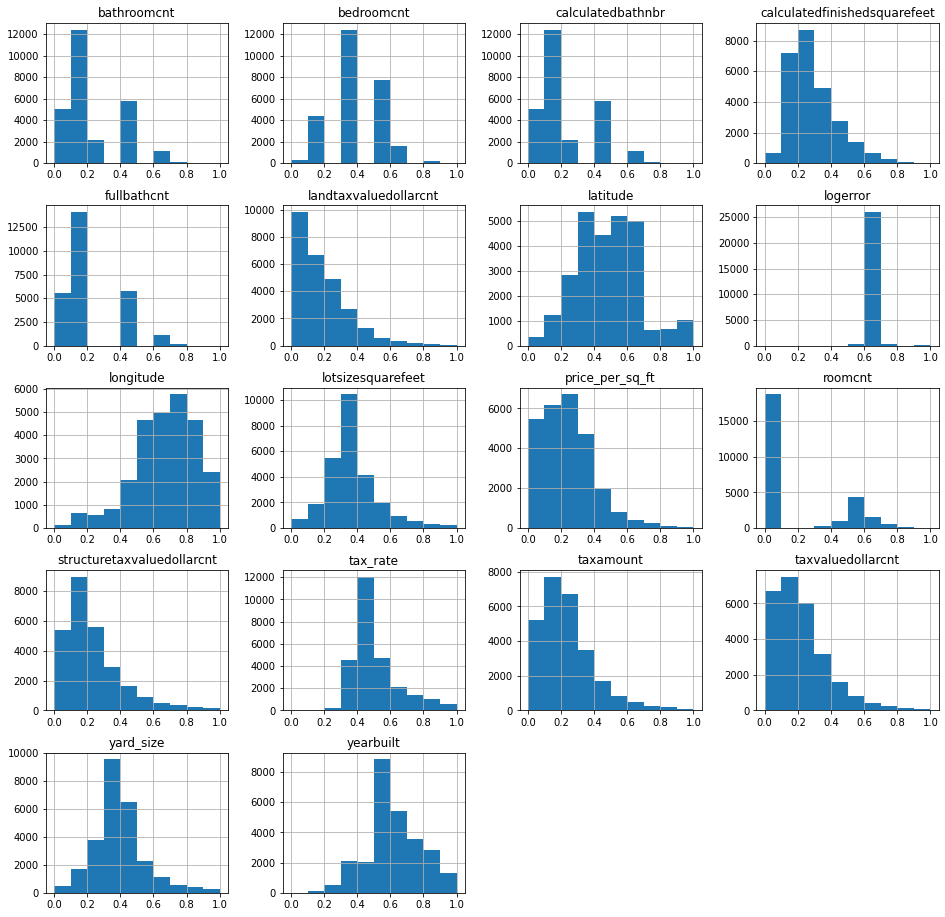

In [24]:
train = wr.convert_dtypes(train, columns=["parcelid", "buildingqualitytypeid", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock"], dtype="object")
train.hist(figsize=(16, 16))
plt.show()

# Explore

In [25]:
# sns.pairplot(data=train.drop(columns=["parcelid", "buildingqualitytypeid", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock"]))

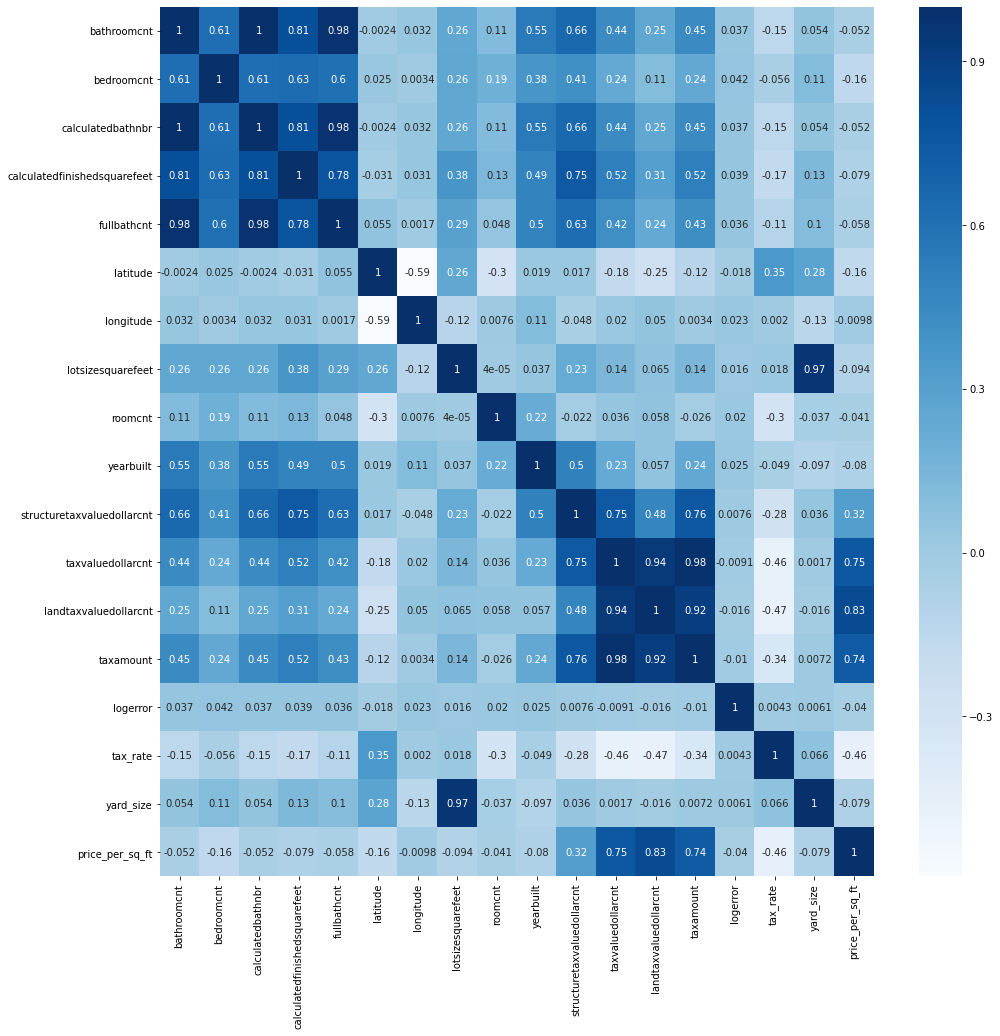

In [26]:
plt.figure(figsize=(16, 16))
sns.heatmap(train.corr(), annot=True, cmap="Blues")
plt.show()

## Cluster the Target Variable
Objectives:
1. Reduce the noise of the continuous variable so that trends in the data are more easily identifiable
2. Compare clusters with other variables through visualizations or hypothesis testing

In [27]:
X = train[["logerror"]]

In [28]:
# inital intuition of 6 clusters
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
kmeans.predict(X)

array([0, 0, 0, ..., 0, 0, 5], dtype=int32)

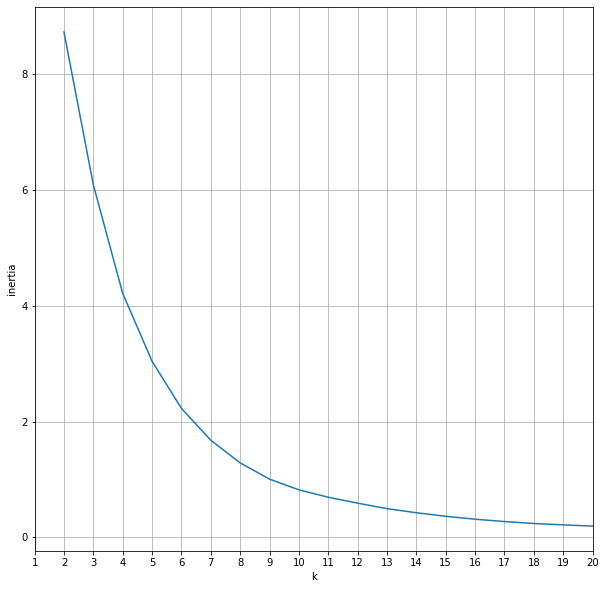

In [29]:
plt.figure(figsize=(10, 10))
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

> **6 or 7 seem like reasonable values for k**

In [30]:
# according to the elbow method above 7 clusters also seems reasonable
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)
train["cluster_target"] = kmeans.predict(X)
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate,yard_size,price_per_sq_ft,cluster_target
35915,12457622,0.0,0.333333,0.2,0.0,0.196721,6037,0.0,0.372619,0.663738,0.390181,0100,0.00636725,46298,3101,96239,0.000000,0,0.328467,0.100685,0.123589,0,0.122217,0.139519,0.00636725,0.639213,2017-07-31,Floor/Wall,Single Family Residential,Los Angeles County,0.494151,0.444233,0.182773,0
40456,12906513,0.2,0.333333,0.5,0.2,0.191389,6037,0.2,0.557788,0.876809,0.415971,0100,0.00404817,39308,3101,96494,0.000000,0,0.620438,0.154533,0.074533,0,0.031406,0.086354,0.00404817,0.638314,2017-08-25,Central,Single Family Residential,Los Angeles County,0.500428,0.473054,0.111496,0
13143,14023137,0.2,0.333333,0.5,0.2,0.223385,6059,0.2,0.268013,0.825818,0.311512,122,0.297302,47568,1286,97004,0.583333,0,0.642336,0.071548,0.037447,0,0.022059,0.051657,0.297302,0.633058,2017-04-04,None,Single Family Residential,Orange County,0.614679,0.353183,0.046645,0
5357,11459439,0.2,0.500000,0.3,0.2,0.256962,6037,0.2,0.456542,0.550515,0.298815,0100,0.00237173,12447,3101,96026,0.000000,0,0.510949,0.210432,0.398417,0,0.433715,0.425683,0.00237173,0.632350,2017-02-13,Floor/Wall,Single Family Residential,Los Angeles County,0.463512,0.329661,0.480345,0
21808,11461483,0.0,0.333333,0.5,0.0,0.194549,6037,0.0,0.452833,0.547211,0.243679,0100,0.00237309,12447,3101,96026,0.000000,0,0.510949,0.298840,0.406335,0,0.401818,0.431475,0.00237309,0.638097,2017-05-22,Floor/Wall,Single Family Residential,Los Angeles County,0.458386,0.290300,0.614044,0


In [31]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,logerror
0,0.639299
1,0.935394
2,0.624473
3,0.665423
4,0.313495
5,0.730975
6,0.566537


In [32]:
train.groupby("cluster_target")["logerror"].mean()

cluster_target
0    0.639310
1    0.935394
2    0.624522
3    0.665423
4    0.313495
5    0.730975
6    0.566669
Name: logerror, dtype: float64

> **There are two centroids for lower (0.29) and upper (0.85) outlier clusters. Generally, the centriods fall in between 0.51 and 0.65 indicating that most of the clusters are grouped close together**

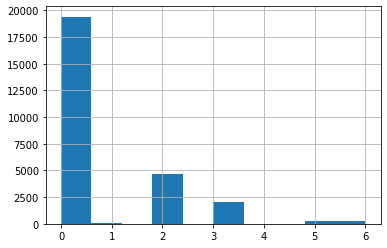

In [33]:
train.cluster_target.hist()

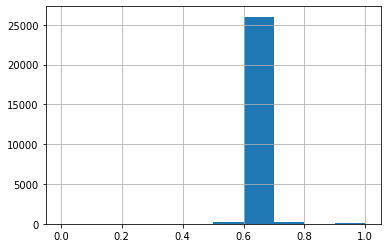

In [34]:
train.logerror.hist()

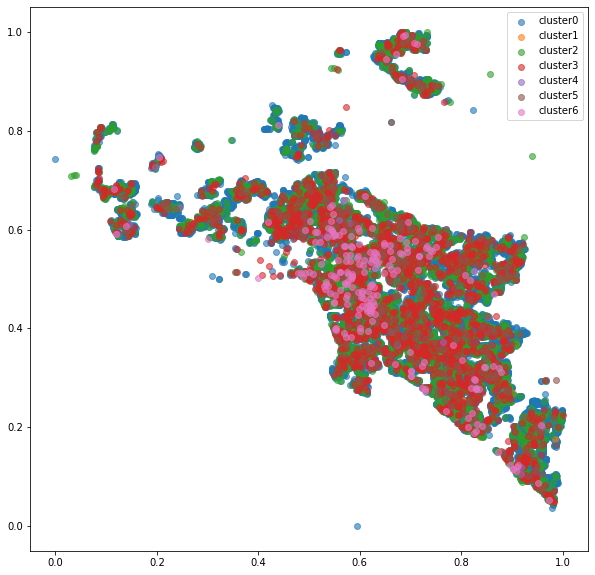

In [35]:
plt.figure(figsize=(10, 10))

for cluster, subset in train.groupby("cluster_target"):
    plt.scatter(subset.longitude, subset.latitude, label="cluster" + str(cluster), alpha=.6)

plt.legend()

> **This visualization leads me to believe that the mean logerror by county is the same.**

$H_0$: The mean logerror by county is the same

$H_0$: The mean logerror by county is different

In [36]:
alpha = .001

la = train[train.county == "Los Angeles County"].logerror
orange = train[train.county == "Orange County"].logerror
ventura = train[train.county == "Ventura County"].logerror

f, p = stats.f_oneway(la, orange, ventura)
print(f"statistic = {f}")
print(f"  p-value = {p}")
print()
if p < alpha:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

statistic = 12.547312509598612
  p-value = 3.5754799354519303e-06

Reject null hypothesis


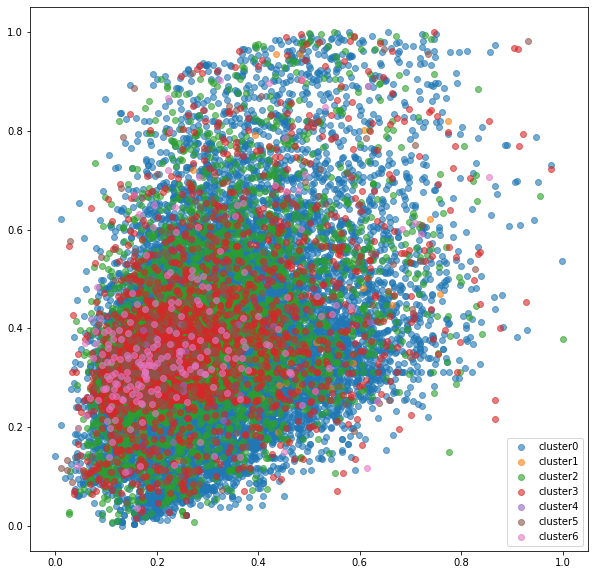

In [37]:
plt.figure(figsize=(10, 10))

for cluster, subset in train.groupby("cluster_target"):
    plt.scatter(subset.calculatedfinishedsquarefeet, subset.lotsizesquarefeet, label="cluster" + str(cluster), alpha=.6)

plt.legend()

## Cluster Independent Variables
### Cluster by Location

In [38]:
X = train[["latitude", "longitude"]]

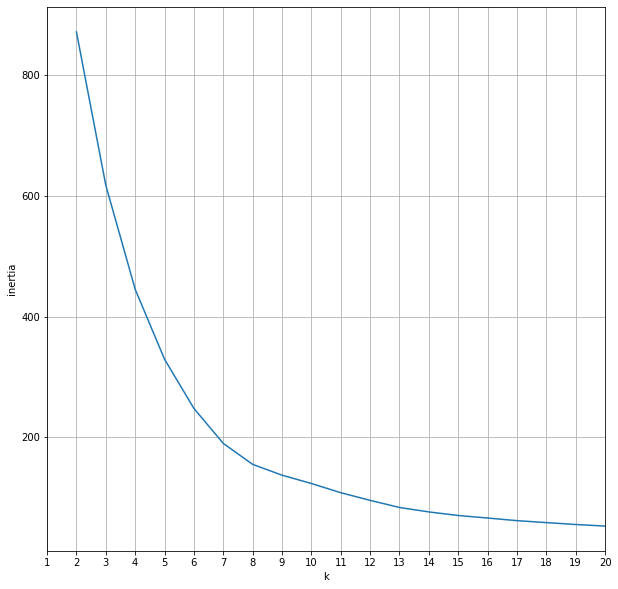

In [39]:
plt.figure(figsize=(10, 10))
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [40]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)
train["location_cluster"] = kmeans.predict(X)

In [41]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,latitude,longitude
0,0.536182,0.770438
1,0.181872,0.925006
2,0.649729,0.511533
3,0.943388,0.688179
4,0.341525,0.790433
5,0.653739,0.228472
6,0.426108,0.610327


In [42]:
train.groupby("location_cluster")["latitude", "longitude"].mean()

,latitude,longitude
location_cluster,,
0,0.536539,0.770420
1,0.181943,0.924920
2,0.649873,0.511212
3,0.943388,0.688179
4,0.341830,0.790246
5,0.653715,0.228112
6,0.426331,0.610180


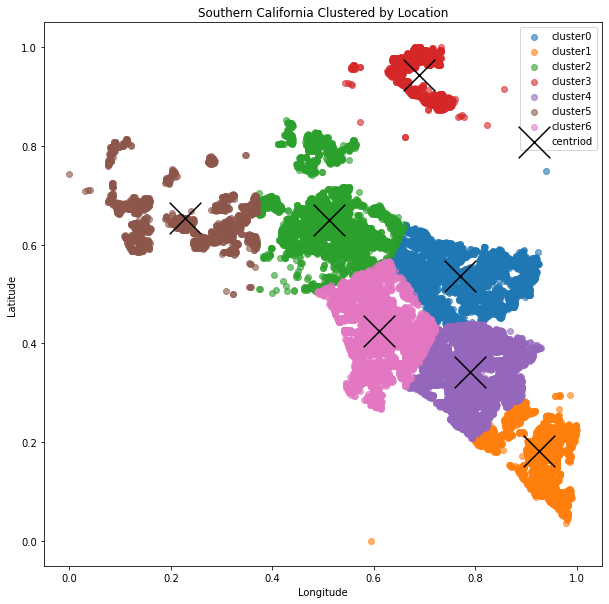

In [43]:
plt.figure(figsize=(10, 10))

for cluster, subset in train.groupby("location_cluster"):
    plt.scatter(subset.longitude, subset.latitude, label="cluster" + str(cluster), alpha=.6)

centriods.plot.scatter(x="longitude", y="latitude", c="black", marker="x", s=1000, ax=plt.gca(), label="centriod")    

plt.legend()
plt.title("Southern California Clustered by Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

> Here we are able to see our properties clustered by geographic location.

---
### Cluster by Size

In [44]:
X = train[["calculatedfinishedsquarefeet", "lotsizesquarefeet"]]

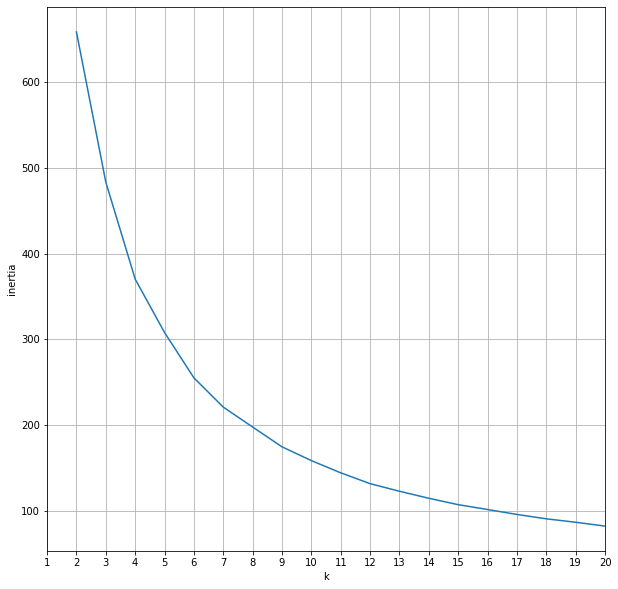

In [45]:
plt.figure(figsize=(10, 10))
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [46]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)
train["size_cluster"] = kmeans.predict(X)

In [47]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,calculatedfinishedsquarefeet,lotsizesquarefeet
0,0.181573,0.301673
1,0.594861,0.435678
2,0.328710,0.589001
3,0.393770,0.311362
4,0.510612,0.818321
5,0.210906,0.129673
6,0.244066,0.407862


In [48]:
train.groupby("size_cluster")["calculatedfinishedsquarefeet", "lotsizesquarefeet"].mean()

,calculatedfinishedsquarefeet,lotsizesquarefeet
size_cluster,,
0,0.181556,0.301702
1,0.595006,0.435809
2,0.328734,0.589038
3,0.394091,0.311116
4,0.510606,0.818506
5,0.210704,0.129652
6,0.244341,0.407735


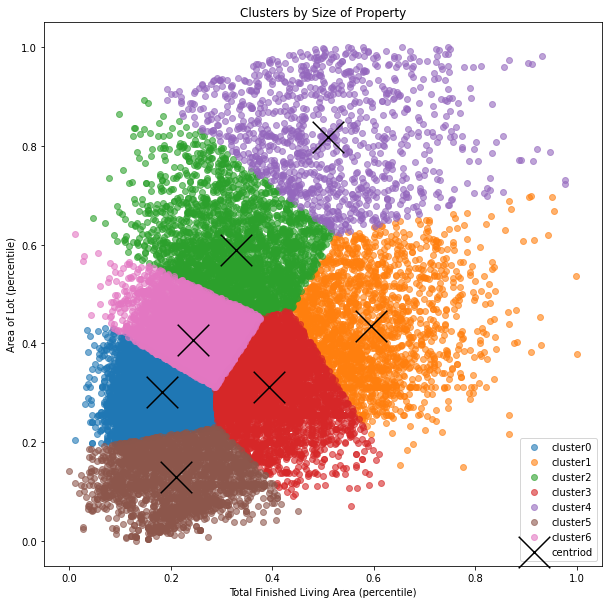

In [49]:
plt.figure(figsize=(10, 10))

for cluster, subset in train.groupby("size_cluster"):
    plt.scatter(subset.calculatedfinishedsquarefeet, subset.lotsizesquarefeet, label="cluster" + str(cluster), alpha=.6)

centriods.plot.scatter(x="calculatedfinishedsquarefeet", y="lotsizesquarefeet", c="black", marker="x", s=1000, ax=plt.gca(), label="centriod")    
    
plt.legend()
plt.title("Clusters by Size of Property")
plt.xlabel("Total Finished Living Area (percentile)")
plt.ylabel("Area of Lot (percentile)")
plt.show()

> Here we are able to see our properties clustered by size. 

---
### Cluster by Location & Size

In [50]:
X = train[["latitude", "longitude", "calculatedfinishedsquarefeet", "lotsizesquarefeet"]]

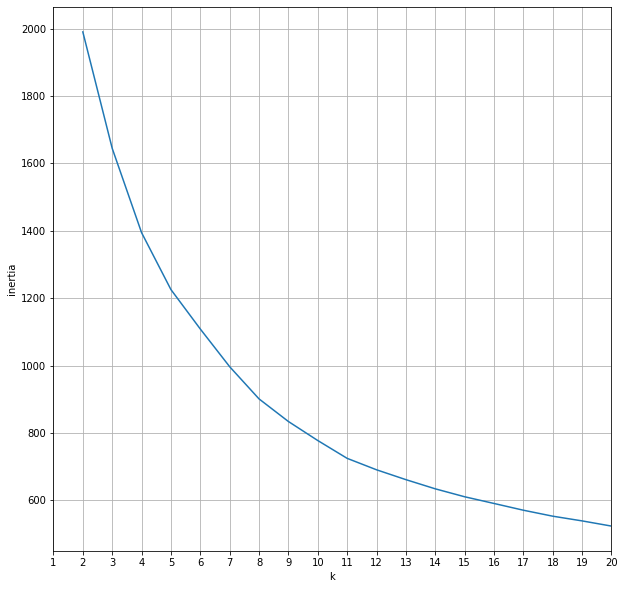

In [51]:
plt.figure(figsize=(10, 10))
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [52]:
kmeans = KMeans(n_clusters=9)
kmeans.fit(X)
train["location_size_cluster"] = kmeans.predict(X)
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate,yard_size,price_per_sq_ft,cluster_target,location_cluster,size_cluster,location_size_cluster
35915,12457622,0.0,0.333333,0.2,0.0,0.196721,6037,0.0,0.372619,0.663738,0.390181,0100,0.00636725,46298,3101,96239,0.000000,0,0.328467,0.100685,0.123589,0,0.122217,0.139519,0.00636725,0.639213,2017-07-31,Floor/Wall,Single Family Residential,Los Angeles County,0.494151,0.444233,0.182773,0,6,6,0
40456,12906513,0.2,0.333333,0.5,0.2,0.191389,6037,0.2,0.557788,0.876809,0.415971,0100,0.00404817,39308,3101,96494,0.000000,0,0.620438,0.154533,0.074533,0,0.031406,0.086354,0.00404817,0.638314,2017-08-25,Central,Single Family Residential,Los Angeles County,0.500428,0.473054,0.111496,0,0,6,1
13143,14023137,0.2,0.333333,0.5,0.2,0.223385,6059,0.2,0.268013,0.825818,0.311512,122,0.297302,47568,1286,97004,0.583333,0,0.642336,0.071548,0.037447,0,0.022059,0.051657,0.297302,0.633058,2017-04-04,None,Single Family Residential,Orange County,0.614679,0.353183,0.046645,0,4,0,3
5357,11459439,0.2,0.500000,0.3,0.2,0.256962,6037,0.2,0.456542,0.550515,0.298815,0100,0.00237173,12447,3101,96026,0.000000,0,0.510949,0.210432,0.398417,0,0.433715,0.425683,0.00237173,0.632350,2017-02-13,Floor/Wall,Single Family Residential,Los Angeles County,0.463512,0.329661,0.480345,0,6,0,0
21808,11461483,0.0,0.333333,0.5,0.0,0.194549,6037,0.0,0.452833,0.547211,0.243679,0100,0.00237309,12447,3101,96026,0.000000,0,0.510949,0.298840,0.406335,0,0.401818,0.431475,0.00237309,0.638097,2017-05-22,Floor/Wall,Single Family Residential,Los Angeles County,0.458386,0.290300,0.614044,0,6,0,0


In [53]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,latitude,longitude,calculatedfinishedsquarefeet,lotsizesquarefeet
0,0.424722,0.640329,0.195601,0.272209
1,0.446365,0.791128,0.236916,0.384554
2,0.637054,0.467464,0.496149,0.641415
3,0.247395,0.862839,0.258048,0.208123
4,0.437795,0.792539,0.406083,0.670142
5,0.630415,0.534078,0.262417,0.372237
6,0.941367,0.686616,0.314181,0.411622
7,0.658262,0.218715,0.293334,0.354069
8,0.245636,0.869715,0.500700,0.369175


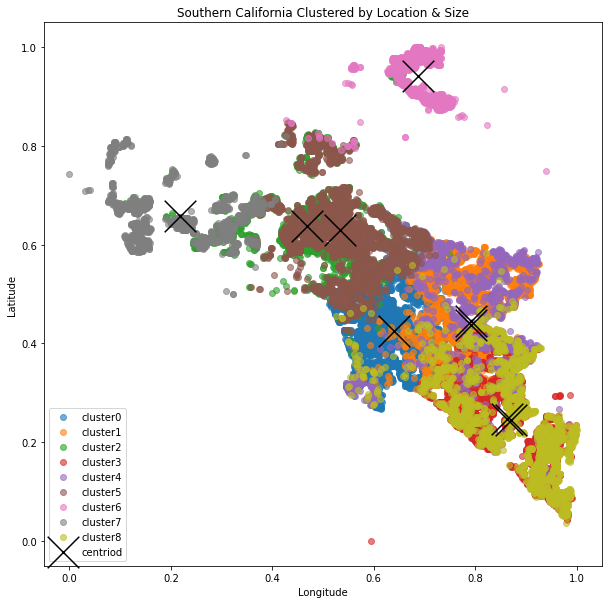

In [54]:
plt.figure(figsize=(10, 10))

for cluster, subset in train.groupby("location_size_cluster"):
    plt.scatter(subset.longitude, subset.latitude, label="cluster" + str(cluster), alpha=.6)

centriods.plot.scatter(x="longitude", y="latitude", c="black", marker="x", s=1000, ax=plt.gca(), label="centriod")    
    
plt.legend()
plt.title("Southern California Clustered by Location & Size")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

> This visulization is not very useful, but we'll keep it to document some exploration.

# Model

In [55]:
pd.options.display.float_format = '{:.3f}'.format

> Let's subset our data to experiment with different models

In [56]:
size_cluster0 = train[train.size_cluster == 0]
size_cluster1 = train[train.size_cluster == 1]
size_cluster2 = train[train.size_cluster == 2]
size_cluster3 = train[train.size_cluster == 3]
size_cluster4 = train[train.size_cluster == 4]
size_cluster5 = train[train.size_cluster == 5]
size_cluster6 = train[train.size_cluster == 6]

---
### size_cluster0 Model 1 logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate

In [57]:
cluster0_predictions = pd.DataFrame({
    "actual_logerror": size_cluster0.logerror,
    "baseline_logerror": size_cluster0.logerror.mean()
})

cluster0_predictions.head()

,actual_logerror,baseline_logerror
13143,0.633,0.639
5357,0.632,0.639
21808,0.638,0.639
924,0.632,0.639
32929,0.660,0.639


In [58]:
X = size_cluster0[["price_per_sq_ft", "buildingqualitytypeid", "tax_rate"]]
# target
y = size_cluster0.logerror

# 1. Make the model
lm = sklearn.linear_model.LinearRegression()
# 2. Fit the model
lm.fit(X, y)
# 3. Use the model
cluster0_predictions["logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate"] = lm.predict(X)
cluster0_predictions.head()

,actual_logerror,baseline_logerror,logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate
13143,0.633,0.639,0.640
5357,0.632,0.639,0.637
21808,0.638,0.639,0.636
924,0.632,0.639,0.638
32929,0.660,0.639,0.639


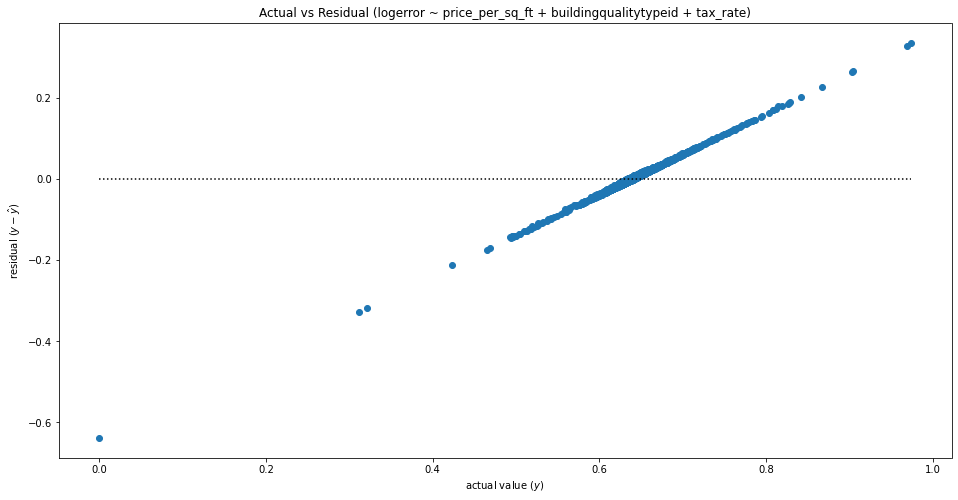

In [59]:
plt.figure(figsize=(16, 8))
ev.plot_residuals(cluster0_predictions.actual_logerror, cluster0_predictions["logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate"])
plt.ticklabel_format(axis="both", style="plain")
plt.show()

In [60]:
print(f"""The equation of our regression line is: 
y = ({lm.coef_[0]:.2f} * price_per_sq_ft) + ({lm.coef_[1]:.2f} * buildingqualitytypeid) + ({lm.coef_[-1]:.2f} * tax_rate) + {lm.intercept_:.2f}""")


The equation of our regression line is: 
y = (-0.01 * price_per_sq_ft) + (-0.00 * buildingqualitytypeid) + (-0.00 * tax_rate) + 0.64


In [61]:
ev.regression_errors(cluster0_predictions.actual_logerror, cluster0_predictions["logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate"], cluster0_predictions)


SSE    4.115
ESS    0.014
TSS    4.128
MSE    0.001
RMSE   0.023
dtype: float64

In [62]:
cluster0_predictions.apply(lambda c: math.sqrt(sklearn.metrics.mean_squared_error(cluster0_predictions.actual_logerror, c)))


actual_logerror                                                 0.000
baseline_logerror                                               0.023
logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate   0.023
dtype: float64

> Our baseline RMSE and model RMSE for logerror are the same.

In [63]:
ev.better_than_baseline(cluster0_predictions.actual_logerror, cluster0_predictions["logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate"], cluster0_predictions.baseline_logerror, cluster0_predictions)

Model performs better than baseline


> According to our better_than_baseline function, our model is performing better than the baseline.

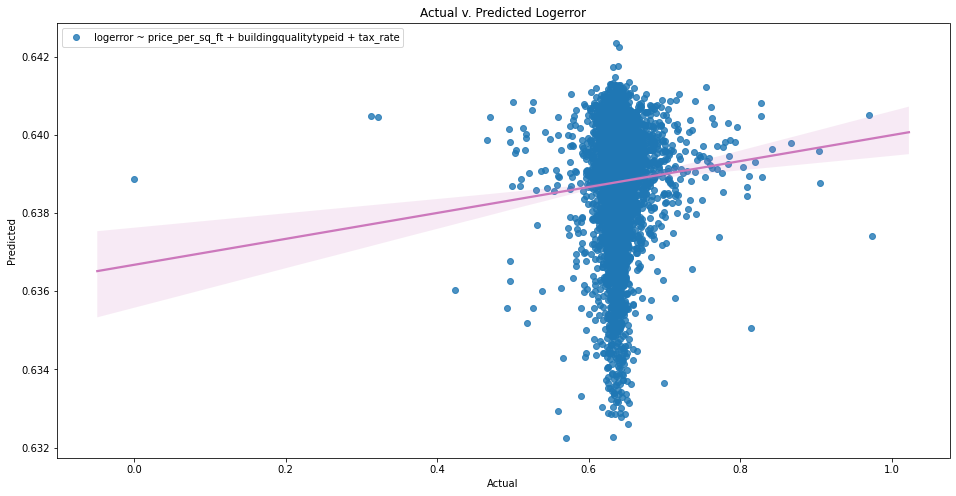

In [64]:
plt.figure(figsize=(16, 8))
sns.regplot(x=cluster0_predictions.actual_logerror, y=cluster0_predictions["logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate"], data=cluster0_predictions, label="logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate", line_kws={"color": sns.color_palette("colorblind")[4]})
plt.ticklabel_format(axis="both", style="plain")

plt.title("Actual v. Predicted Logerror")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()

plt.show()

---
### size_cluster0 Model 2 logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet¶

In [65]:
X = size_cluster0[["calculatedfinishedsquarefeet", "lotsizesquarefeet"]]
# target
y = size_cluster0.logerror

# 1. Make the model
lm = sklearn.linear_model.LinearRegression()
# 2. Fit the model
lm.fit(X, y)
# 3. Use the model
cluster0_predictions["logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet"] = lm.predict(X)
cluster0_predictions.head()

,actual_logerror,baseline_logerror,logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate,logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet
13143,0.633,0.639,0.640,0.639
5357,0.632,0.639,0.637,0.639
21808,0.638,0.639,0.636,0.639
924,0.632,0.639,0.638,0.639
32929,0.660,0.639,0.639,0.639


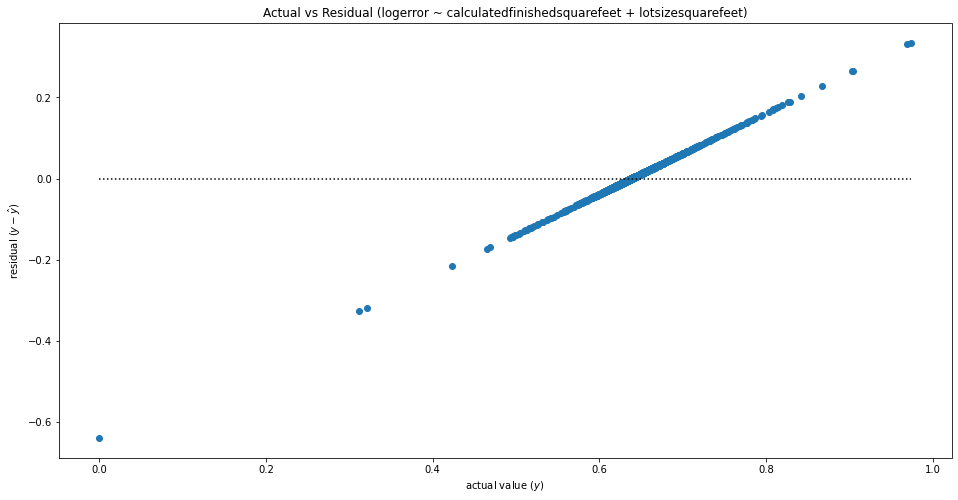

In [66]:
plt.figure(figsize=(16, 8))
ev.plot_residuals(cluster0_predictions.actual_logerror, cluster0_predictions["logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet"])
plt.ticklabel_format(axis="both", style="plain")
plt.show()

In [67]:
print(f"""The equation of our regression line is: 
y = ({lm.coef_[0]:.2f} * calculatedfinishedsquarefeet) + ({lm.coef_[1]:.2f} * lotsizesquarefeet) + {lm.intercept_:.2f}""")


The equation of our regression line is: 
y = (0.01 * calculatedfinishedsquarefeet) + (0.00 * lotsizesquarefeet) + 0.64


In [68]:
ev.regression_errors(cluster0_predictions.actual_logerror, cluster0_predictions["logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet"], cluster0_predictions)


SSE    4.127
ESS    0.001
TSS    4.128
MSE    0.001
RMSE   0.023
dtype: float64

In [69]:
cluster0_predictions.apply(lambda c: math.sqrt(sklearn.metrics.mean_squared_error(cluster0_predictions.actual_logerror, c)))


actual_logerror                                                 0.000
baseline_logerror                                               0.023
logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate   0.023
logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet     0.023
dtype: float64

> Our baseline RMSE and model RMSE for logerror are the same.

In [70]:
ev.better_than_baseline(cluster0_predictions.actual_logerror, cluster0_predictions["logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet"], cluster0_predictions.baseline_logerror, cluster0_predictions)

Model performs better than baseline


> According to our better_than_baseline function, our model is performing better than the baseline.

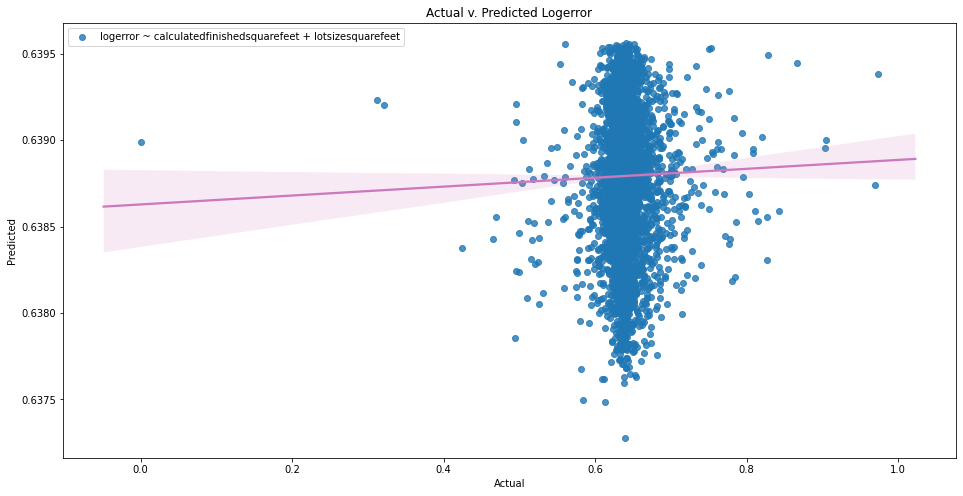

In [71]:
plt.figure(figsize=(16, 8))
sns.regplot(x=cluster0_predictions.actual_logerror, y=cluster0_predictions["logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet"], data=cluster0_predictions, label="logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet", line_kws={"color": sns.color_palette("colorblind")[4]})
plt.ticklabel_format(axis="both", style="plain")

plt.title("Actual v. Predicted Logerror")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()

plt.show()

---
### size_cluster0 Model 3 - RFE

In [72]:
X = size_cluster0.drop(columns=["parcelid", "buildingqualitytypeid", "fips", "propertycountylandusecode", "regionidcity", "regionidcounty", "regionidzip", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock", "transactiondate", "heatingorsystemdesc", "propertylandusedesc", "county", "logerror"])
y = size_cluster0.logerror

In [73]:
k = 4
lm = sklearn.linear_model.LinearRegression()

In [74]:
rfe = RFE(lm, k)
rfe.fit(X, y)
print(f'selected top {k} features:', X.columns[rfe.support_])

selected top 4 features: Index(['bathroomcnt', 'calculatedbathnbr', 'fullbathcnt', 'taxamount'], dtype='object')


In [75]:
X_rfe = rfe.transform(X)
X_rfe

array([[0.2       , 0.2       , 0.2       , 0.05165705],
       [0.2       , 0.2       , 0.2       , 0.42568251],
       [0.        , 0.        , 0.        , 0.43147486],
       ...,
       [0.4       , 0.4       , 0.4       , 0.14171945],
       [0.2       , 0.2       , 0.2       , 0.19686398],
       [0.        , 0.        , 0.        , 0.01752773]])

In [76]:
lm.fit(X_rfe, y)
cluster0_predictions['multiple_rfe'] = lm.predict(X_rfe)
cluster0_predictions

,actual_logerror,baseline_logerror,logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate,logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet,multiple_rfe
13143,0.633,0.639,0.640,0.639,0.640
5357,0.632,0.639,0.637,0.639,0.636
21808,0.638,0.639,0.636,0.639,0.635
924,0.632,0.639,0.638,0.639,0.638
32929,0.660,0.639,0.639,0.639,0.638
...,...,...,...,...,...
34769,0.661,0.639,0.638,0.639,0.637
40069,0.638,0.639,0.638,0.639,0.638
23934,0.638,0.639,0.639,0.638,0.641
20006,0.638,0.639,0.639,0.640,0.639


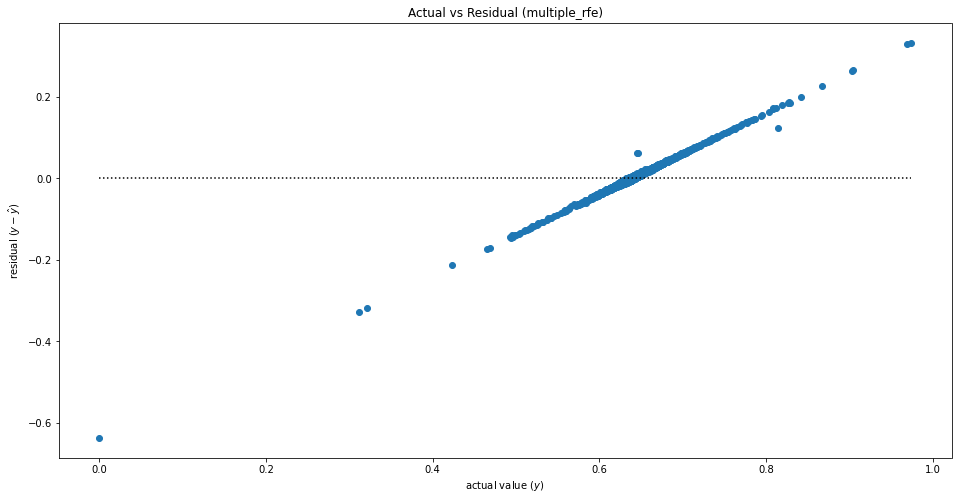

In [77]:
plt.figure(figsize=(16, 8))
ev.plot_residuals(cluster0_predictions.actual_logerror, cluster0_predictions.multiple_rfe)
plt.ticklabel_format(axis="both", style="plain")
plt.show()

In [78]:
print(f"""The equation of our regression line is: 
y = ({lm.coef_[0]:.2f} * {X.columns[rfe.support_][0]}) + ({lm.coef_[1]:.2f} * {X.columns[rfe.support_][1]}) + ({lm.coef_[2]:.2f} * {X.columns[rfe.support_][2]}) + ({lm.coef_[3]:.2f} * {X.columns[rfe.support_][3]}) + {lm.intercept_:.2f}""")


The equation of our regression line is: 
y = (0.55 * bathroomcnt) + (-0.51 * calculatedbathnbr) + (-0.03 * fullbathcnt) + (-0.01 * taxamount) + 0.64


In [79]:
ev.regression_errors(cluster0_predictions.actual_logerror, cluster0_predictions.multiple_rfe, cluster0_predictions)


SSE    4.104
ESS    0.024
TSS    4.128
MSE    0.001
RMSE   0.022
dtype: float64

In [80]:
cluster0_predictions.apply(lambda c: math.sqrt(sklearn.metrics.mean_squared_error(cluster0_predictions.actual_logerror, c)))


actual_logerror                                                 0.000
baseline_logerror                                               0.023
logerror ~ price_per_sq_ft + buildingqualitytypeid + tax_rate   0.023
logerror ~ calculatedfinishedsquarefeet + lotsizesquarefeet     0.023
multiple_rfe                                                    0.022
dtype: float64

> Our baseline RMSE and model RMSE for logerror are the same.

In [81]:
ev.better_than_baseline(cluster0_predictions.actual_logerror, cluster0_predictions.multiple_rfe, cluster0_predictions.baseline_logerror, cluster0_predictions)

Model performs better than baseline


> According to our better_than_baseline function, our model is performing better than the baseline.

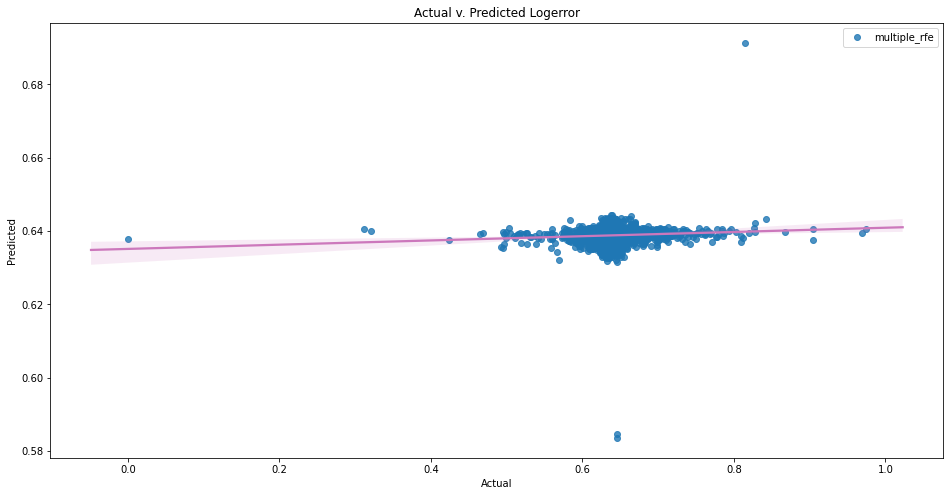

In [82]:
plt.figure(figsize=(16, 8))
sns.regplot(x=cluster0_predictions.actual_logerror, y=cluster0_predictions.multiple_rfe, data=cluster0_predictions, label="multiple_rfe", line_kws={"color": sns.color_palette("colorblind")[4]})
plt.ticklabel_format(axis="both", style="plain")

plt.title("Actual v. Predicted Logerror")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()

plt.show()